In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

In [4]:
def calculate_difference_image(image1, image2):
    return cv2.absdiff(image1, image2)


In [3]:
def load_images_and_difference(authentic_dir, tampered_dir):
    images = []
    labels = []

    # Load and process authentic images
    print("Loading authentic images...")
    for filename in os.listdir(authentic_dir):
        if filename.lower().endswith(('.jpg', '.bmp')):
            filepath = os.path.join(authentic_dir, filename)
            img = cv2.imread(filepath, cv2.IMREAD_COLOR)
            if img is not None:
                img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0
                images.append(img_resized)
                labels.append(0)

    print("Loading tampered images and calculating differences...")
    # Process tampered images and calculate differences
    for filename in os.listdir(tampered_dir):
        if filename.lower().endswith(('.jpg', '.tif')):
            tampered_img = cv2.imread(os.path.join(tampered_dir, filename), cv2.IMREAD_COLOR)
            tampered_img_resized = cv2.resize(tampered_img, (224, 224)).astype(np.float32) / 255.0
            
            # Try to find a matching authentic image
            match_found = False
            parts = filename.split("_")
            if len(parts) >= 7:
                source_id = parts[4][:3] + "_" + parts[4][3:]
                target_id = parts[5][:3] + "_" + parts[5][3:]
                for id_ in [source_id, target_id]:
                    for ext in ['.jpg', '.bmp']:
                        auth_filename = f"Au_{id_}{ext}"
                        auth_filepath = os.path.join(authentic_dir, auth_filename)
                        if os.path.exists(auth_filepath):
                            auth_img = cv2.imread(auth_filepath, cv2.IMREAD_COLOR)
                            auth_img_resized = cv2.resize(auth_img, (224, 224)).astype(np.float32) / 255.0
                            difference_img = calculate_difference_image(tampered_img_resized, auth_img_resized)
                            images.append(difference_img)
                            labels.append(1)
                            match_found = True
                            break
            if not match_found:
                print(f"No authentic match found for {filename}, using tampered image directly.")
                images.append(tampered_img_resized)
                labels.append(1)

    return np.array(images), np.array(labels)



In [4]:
authentic_dir = 'D:\Studies\Mini prjt\CASIA2\Au'
tampered_dir = 'D:\Studies\Mini prjt\CASIA2\Tp'

In [5]:
print("Starting image loading process...")
images, labels = load_images_and_difference(authentic_dir, tampered_dir)
print("Image loading complete.")

Starting image loading process...
Loading authentic images...
Loading tampered images and calculating differences...
No authentic match found for Tp_S_CNN_S_N_cha0003_cha00003_00323.tif, using tampered image directly.
No authentic match found for Tp_S_NNN_M_N_pla0006_pla00006_01128.tif, using tampered image directly.
Image loading complete.


In [6]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Train set size: 10091, Test set size: 2523


In [8]:
def display_difference_example(authentic_dir, tampered_dir):
    # Pick a random tampered image
    tampered_files = [f for f in os.listdir(tampered_dir) if f.lower().endswith(('.jpg', '.tif'))]
    chosen_file = np.random.choice(tampered_files)
    tampered_img = cv2.imread(os.path.join(tampered_dir, chosen_file), cv2.IMREAD_COLOR)
    tampered_img_resized = cv2.resize(tampered_img, (224, 224))

    # Find its corresponding authentic image
    parts = chosen_file.split("_")
    if len(parts) >= 7:
        source_id = parts[4][:3] + "_" + parts[4][3:]
        target_id = parts[5][:3] + "_" + parts[5][3:]
        for id_ in [source_id, target_id]:
            for ext in ['.jpg', '.bmp']:
                auth_filename = f"Au_{id_}{ext}"
                auth_filepath = os.path.join(authentic_dir, auth_filename)
                if os.path.exists(auth_filepath):
                    auth_img = cv2.imread(auth_filepath, cv2.IMREAD_COLOR)
                    auth_img_resized = cv2.resize(auth_img, (224, 224))

                    # Calculate difference image
                    difference_img = calculate_difference_image(tampered_img_resized, auth_img_resized)

                    # Display images
                    plt.figure(figsize=(12, 4))
                    plt.subplot(1, 3, 1)
                    plt.imshow(cv2.cvtColor(tampered_img_resized, cv2.COLOR_BGR2RGB))
                    plt.title('Tampered Image')
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(cv2.cvtColor(auth_img_resized, cv2.COLOR_BGR2RGB))
                    plt.title('Authentic Image')
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(cv2.cvtColor(difference_img, cv2.COLOR_BGR2RGB))
                    plt.title('Difference Image')
                    plt.axis('off')

                    plt.show()
                    return

    print("No matching example found or unable to load images.")

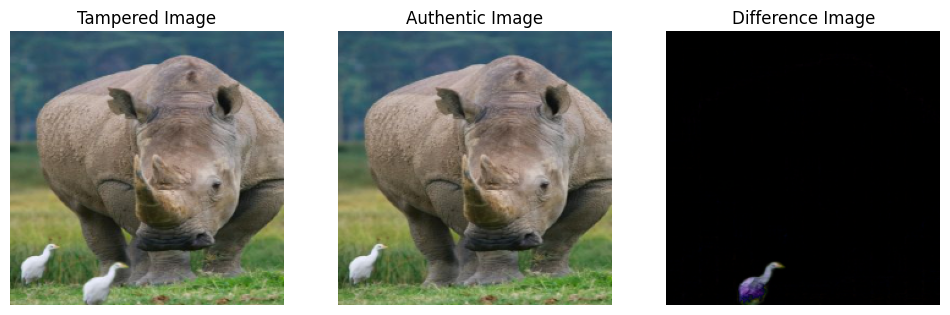

In [9]:
display_difference_example('D:\Studies\Mini prjt\CASIA2\Au', 'D:\Studies\Mini prjt\CASIA2\Tp')

In [7]:
# Load the base VGG16 model, pre-trained on ImageNet, without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Loaded VGG16 base model.")


Loaded VGG16 base model.


In [8]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
print("Frozen the base model layers.")

Frozen the base model layers.


In [9]:
# Create a new top layer for binary classification
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Helps prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification layer

In [10]:
# Construct the complete model
model = Model(inputs=base_model.input, outputs=predictions)
print("Added new layers for binary classification.")

Added new layers for binary classification.


In [11]:
# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
print("Compiled the model with Adam optimizer and binary cross-entropy loss.")

Compiled the model with Adam optimizer and binary cross-entropy loss.


In [12]:
# Callback to monitor training
class TrainingMonitor(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch+1}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch+1}")
        print(f"Loss: {logs['loss']}, Accuracy: {logs['accuracy']}, Val Loss: {logs['val_loss']}, Val Accuracy: {logs['val_accuracy']}")


In [13]:
# Function to train the model
def train_model(model, X_train, y_train, X_test, y_test):
    print("Starting model training...")
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[TrainingMonitor()],
        verbose=2  # Set verbose to 2 for less verbosity but enough to see progress per epoch
    )
    print("Training complete.")
    return history

In [14]:
# Call the train_model function directly with the data
history= train_model(model, X_train, y_train, X_test, y_test)

Starting model training...
Starting epoch 1
Epoch 1/10
Finished epoch 1
Loss: 0.08782839775085449, Accuracy: 0.9696759581565857, Val Loss: 0.049137748777866364, Val Accuracy: 0.9805786609649658
316/316 - 1657s - loss: 0.0878 - accuracy: 0.9697 - val_loss: 0.0491 - val_accuracy: 0.9806 - 1657s/epoch - 5s/step
Starting epoch 2
Epoch 2/10
Finished epoch 2
Loss: 0.03933228924870491, Accuracy: 0.9863244295120239, Val Loss: 0.04519917815923691, Val Accuracy: 0.9885057210922241
316/316 - 1671s - loss: 0.0393 - accuracy: 0.9863 - val_loss: 0.0452 - val_accuracy: 0.9885 - 1671s/epoch - 5s/step
Starting epoch 3
Epoch 3/10
Finished epoch 3
Loss: 0.02842586487531662, Accuracy: 0.990387499332428, Val Loss: 0.030527660623192787, Val Accuracy: 0.9916765689849854
316/316 - 1795s - loss: 0.0284 - accuracy: 0.9904 - val_loss: 0.0305 - val_accuracy: 0.9917 - 1795s/epoch - 6s/step
Starting epoch 4
Epoch 4/10
Finished epoch 4
Loss: 0.020425816997885704, Accuracy: 0.9932613372802734, Val Loss: 0.04127712175

In [15]:
# Evaluate the model
final_loss, final_accuracy = model.evaluate(X_test, y_test)
print(f"Final test loss: {final_loss}, Final test accuracy: {final_accuracy}")

79/79 [==============================] - 311s 4s/step - loss: 0.0334 - accuracy: 0.9929
Final test loss: 0.03336768597364426, Final test accuracy: 0.9928656220436096


In [16]:
# Save the entire model
model.save('VGG16_BC.h5')
print("Saved model to disk.")

Saved model to disk.


In [3]:
def prepare_single_image(test_image_path, reference_image_path):
    # Load and resize the test image
    test_img = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
    test_img_resized = cv2.resize(test_img, (224, 224)).astype(np.float32) / 255.0

    # Load and resize the reference image
    reference_img = cv2.imread(reference_image_path, cv2.IMREAD_COLOR)
    reference_img_resized = cv2.resize(reference_img, (224, 224)).astype(np.float32) / 255.0

    # Calculate the difference image
    difference_img = calculate_difference_image(test_img_resized, reference_img_resized)
    difference_img = np.expand_dims(difference_img, axis=0)  # Expanding dimensions for the model
    return difference_img

In [5]:
model = load_model('VGG16_BC.h5')
print("Loaded the entire model from disk.")

test_image_path = r'D:\Studies\Mini prjt\CASIA2\Tp\Tp_D_CNN_M_N_nat00089_nat00062_10577.jpg'
reference_image_path = r'D:\Studies\Mini prjt\CASIA2\Au\Au_nat_00089.jpg'

try:
    difference_image = prepare_single_image(test_image_path, reference_image_path)
    prediction = model.predict(difference_image)
    print(f"Prediction (0 for Authentic, 1 for Tampered): {prediction[0]}")
    if prediction[0] > 0.5:
        print("The image is likely tampered.")
    else:
        print("The image is likely authentic.")
except Exception as e:
    print(e)

Loaded the entire model from disk.
1/1 [==============================] - 0s 354ms/step
Prediction (0 for Authentic, 1 for Tampered): [0.9752564]
The image is likely tampered.
